In [ ]:
#install needed libraries
!pip install git+https://github.com/albumentations-team/albumentations
!pip install tensorflow
!pip install -U tensorflow-addons

In [ ]:
import os
# !pip install shutil
import shutil
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix as cm

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB6 as efficientnet
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.resnet50 import ResNet50 as rs50
import tensorflow.keras.applications.xception as xception
AUTOTUNE = tf.data.AUTOTUNE

import tensorflow_addons as tfa

import seaborn as sns
import matplotlib.pyplot as plt

# if have trouble installing/importing albumentations package , 
# try updating pip: pip install --upgrade pip
import albumentations as A

import cv2

from collections import Counter
from google.colab.patches import cv2_imshow





In [ ]:
#mount google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Set folder locations

In [ ]:
#set path to cervAI folder shortcut within local gdrive
project_folder = os.path.join('content/drive/MyDrive','cerv_AI')
project_folder = '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi'

data_folder = os.path.join(project_folder,'Data')
raw_data_folder = os.path.join(project_folder,'Data/raw')
structured_data_folder = os.path.join(project_folder,'Data/Structured')

# mixed_dir2 = os.path.join(data_folder,'CervAI2')
mixed_dir2 = os.path.join(data_folder,'CervAI2_minside300')

models_folder = os.path.join(data_folder,'saved_models')
mixed_models_current = os.path.join(models_folder,'mixed_model/best_weights_current_run/')
mixed_models_best = os.path.join(models_folder,'mixed_model/best_weights_all_runs/')

## Get images paths and labels

In [ ]:
def count_classes(label_array):
  #function to look at array of labels and count number of examples in each class
  label_list = label_array.flatten().tolist()
  print('total images = ',len(label_list))
  counter_dict = Counter(label_list)
  return counter_dict

def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    
    for root, dirnames, filenames in os.walk(input_dir): #look at all folders and subfolders and get the filenames
      for class_label in dirnames:
        filenames = os.listdir(os.path.join(root,class_label))
        for filename in filenames: #loop through filenames
          temp_path = os.path.join(root,class_label,filename) # temp filepath
          image_paths.append(temp_path) # add to image paths list
          temp_label = class_label
          labels.append(temp_label) # add label to label list

    #convert list into array
    image_paths = np.asarray(image_paths)
    labels_array = np.array(labels)
    # labels_array = labels_array.astype(int)
    return image_paths, labels_array

#get the image paths and labels from both training and validation sets
train_image_paths_mixed , train_image_labels_mixed = get_files_labels(os.path.join(mixed_dir2,'train'))
val_image_paths_mixed , val_image_labels_mixed = get_files_labels(os.path.join(mixed_dir2,'val'))




In [ ]:
#join the training and validation sets together to be upsampled and shuffled
all_image_paths_mixed = np.concatenate((train_image_paths_mixed,val_image_paths_mixed))
all_image_labels_mixed = np.concatenate((train_image_labels_mixed,val_image_labels_mixed))

In [ ]:
#check how many examples we have in each class before upsampling
count_classes(all_image_labels_mixed)

total images =  7901


Counter({'NILM': 1599,
         'SCC': 399,
         'LSIL': 831,
         'ASC-US': 601,
         'ASC-H': 1186,
         'HSIL': 3285})

In [ ]:
#convert text labels to numeric
def map_text_to_num(input_label):
  input_labels = {'NL':0 , 'ASC-US':1, 'ASC-H':2,'LSIL':3,'HSIL':4,'SCC':5, 'NILM':0}
  output_cn = input_labels[input_label]
  return output_cn

#turn text labels into numeric labels
vfunc = np.vectorize(map_text_to_num)
all_image_labels_mixed_num = vfunc(all_image_labels_mixed)

#look at 10 random examples to make sure the transformation was applied correctly
print(np.random.choice(all_image_labels_mixed_num,10))

[4 4 0 0 1 4 3 2 4 4]


## make train/val/test splits

In [ ]:
def upsample_file_paths_labels(file_paths_array,labels, max_class_amount):
  '''
  This function upsamples the images to achieve a roughly equal number of images in each class. 
  This should help the model better differentiate between the different classes
  Inputs: 

  file_paths_array: A numpy array of filepaths pointing to the images 
  labels: A numpy array of labels giving the associated bethesda classification for each image
  max_class_amount: An integer which gives the number of examples desired for each class

  Outputs
  returns two variables: new_filepaths,new_labels (both numpy arrays) where the new filepaths and labels will have a greater number than
  the input arrays and the classes will be balanced to max_class_amount
  '''
  #make empty lists
  new_filepaths = []
  new_labels = []
 
  #set local variable from input variable
  max_class_amount = max_class_amount

  #loop through classes as numbers
  for x in range(0,6): 
    #find indices where labels match class label
    indices_matching_class = np.argwhere(labels==x).reshape(-1) #make argwhere output 1 dimensional
   
    #upsample indices
    upsampled_indices = np.random.choice(indices_matching_class,size=max_class_amount,replace=True) #keep choosing indices that match class label of interest until we have n=max_class_amount of examples for current class
    
    #using the upsampled indices, we use array indexing to create an upsampled array of filepaths and associated labels
    upsampled_filepaths = file_paths_array[upsampled_indices]
    upsampled_labels = labels[upsampled_indices]
    
    #On a per class level, we add the expanded filepaths and labels to our lists
    new_filepaths.append(upsampled_filepaths)
    new_labels.append(upsampled_labels)

  #now we have two lists each containing 6 elements (1 per class) where each element contains n=max_class_amount examples
  #we flatten both lists to get them back into a 1D format (each list now has 6*n elements). We also turn the lists into np arrays for easier pre-processing in the future
  new_filepaths = np.asarray(new_filepaths).flatten()
  new_labels = np.asarray(new_labels).flatten()
  return new_filepaths,new_labels

def make_train_test_splits(file_paths_array,labels,upsample=False, return2vals=False, max_class_amount=1000):
  '''
  This function will take arrays of filepaths and labels, upsample them if needed and then split them into training and validation datasets.
  If desired two validation sets can be outputted which is useful for training meta-models or ensemble methods

  Inputs:
  file_paths_array: A numpy array of filepaths pointing to the images 
  labels: A numpy array of labels giving the associated bethesda classification for each image
  upsample: Boolean - whether to upsample and balance the image classes or to retain the original number of each class
  return2vals: Boolean - whether to return two validation sets. Set to true if a meta-model or ensemble model will be trained. Otherwise set to False.
  max_class_amount: Integer - if upsample = True, the desired number of each class type

  Outputs:
  if return2vals = True: return numpy arrays for x_train, y_train, x_val_1, y_val_1, x_val_2, y_val_2
  if return2vals = False: return numpy arrays for x_train, y_train, x_val_out, y_val_out
  '''
  #upsample if needed
  if upsample == True:
    new_file_paths , new_labels = upsample_file_paths_labels(file_paths_array,labels,max_class_amount)
  else:
    new_file_paths = file_paths_array
    new_labels = labels

  #split filepaths and labels into train/validation splits 
  x_train, x_val, y_train, y_val = train_test_split(new_file_paths, new_labels, train_size = 0.9, random_state=42, shuffle=True)
  x_val_1, x_val_2, y_val_1, y_val_2 = train_test_split(x_val, y_val, train_size = 0.7, random_state=42, shuffle=True)

  #show number of examples in each dataset
  print(len(x_train))
  print(len(y_train))
  print(len(x_val))
  print(len(y_val_1))
  print(len(x_val_1))
  print(len(y_val_1))
  
  #inverse transform each class label dataset so we can get the class amounts within each dataset
  print('count labels in each set:')
  for item in [y_train, y_val]:
    print(count_classes(item))

  print('train val test splits created')

  #if it is not needed to make two validation datasets, we join the validation sets back together
  if return2vals == False:
    x_val_out = np.concatenate([x_val_1,x_val_2])
    y_val_out = np.concatenate([y_val_1,y_val_2])
    return x_train, y_train, x_val_out, y_val_out
  else:
    return x_train, y_train, x_val_1, y_val_1, x_val_2, y_val_2

#create train/val/test splits
x_train_mi, y_train_mi, x_val_1_mi, y_val_1_mi = make_train_test_splits(all_image_paths_mixed, 
                                                                      all_image_labels_mixed_num, 
                                                                      upsample=True, 
                                                                      return2vals = False,
                                                                      max_class_amount=1200)


6480
6480
720
503
503
503
count labels in each set:
total images =  6480
Counter({5: 1087, 3: 1086, 4: 1083, 2: 1077, 1: 1077, 0: 1070})
total images =  720
Counter({0: 130, 2: 123, 1: 123, 4: 117, 3: 114, 5: 113})
train val test splits created


In [ ]:
print(np.random.choice(x_train_mi,100))

['/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/CervAI2_minside300/train/SCC/SCC_2 (3)_MEND.jpg'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/CervAI2_minside300/train/HSIL/HSIL_02882_CDET.jpg'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/CervAI2_minside300/train/SCC/SCC_05051_CDET.jpg'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/CervAI2_minside300/val/NILM/NILM_43_ (11)_MEND.jpg'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/CervAI2_minside300/train/ASC-US/ASC-US_02211_CDET.jpg'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/CervAI2_minside300/train/SCC/SCC_01802_CDET.jpg'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPo

## convert labels to one hot encoding

In [ ]:
#we convert our integer labels into one-hot encoded format so the models can better learn the expected output
# this also lets us output probabilites for each class


from sklearn.preprocessing import OneHotEncoder
# input_labels = [0,1,2,3,4,5]
enc = OneHotEncoder(handle_unknown='error')
#we fit the one-hot encoder on the existing input data
enc.fit(all_image_labels_mixed_num.reshape(-1, 1)) 

#transform our image labels from class integers to one-hot format
y_train_mi_oh =  enc.transform(y_train_mi.reshape(-1, 1)).toarray()
y_val_1_mi_oh =  enc.transform(y_val_1_mi.reshape(-1, 1)).toarray()
# y_val_2_mi_oh =  enc.transform(y_val_2_mi.reshape(-1, 1)).toarray()


#we test the 6 possible one-hot encoded labels to make sure they map back to the correct bethesda class
testing = [[1,0,0,0,0,0],
           [0,1,0,0,0,0],
           [0,0,1,0,0,0],
           [0,0,0,1,0,0],
           [0,0,0,0,1,0],
           [0,0,0,0,0,1]]
testing_inv = enc.inverse_transform(testing)
print(testing_inv)
print(y_train_mi_oh[0:5])
# one_hot_labels[0:5]

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


## define our transformations here

Now we define the transformations that will be applied to the images before they are fed into the model.

We use the albumentations library which allows us to chain together image transformations. 

We define a desired image size and then we apply a resizing transformation to make the images smaller (to speed up mode training time). We then apply a number of image augmentations which serve to make the training data more varied and hopefully cause the model to learn different features of interest fro mthe input images depending on which image augmentations were applied.


In [ ]:
TARGET_ASPECT_RATIO = 1.5
TARGET_LONGEST_SIDE = 300
#we define target dimensions of the image to be passed into the model by setting desired longest size 
#(normally width) of the image and also the desired aspect ratio. Aspect ratio was chosen to try and minimise distortion for the most number of images
TARGET_DIMS = (int(TARGET_LONGEST_SIDE/TARGET_ASPECT_RATIO),TARGET_LONGEST_SIDE)

# We define the resizing transformation
# A.LongestMaxSize - shrinks image maintaining aspect ratio
# We apply a horizontal or vertical flip so the model does not learn to just look at certain parts of the image
# Then we squash the height to finally get the required image dimensions

resize_tr = A.Compose([
    A.LongestMaxSize(max_size=TARGET_DIMS[1],p=1,interpolation=cv2.INTER_LANCZOS4),
    A.OneOf([
      A.VerticalFlip(p=0.5),
      A.HorizontalFlip(p=0.5)]),
    A.Resize(TARGET_DIMS[0],TARGET_DIMS[1])
    ])

#Now we define our image augmentations transformations
#We choose one of 
# A.GaussianBlur - blurs the image, reproducing the effect of less detailed microscopes/scanners and hopefully forcing the model to look at general colours and nuclei as cell borders are blurred away
# A.Emboss - highlights the edges in an image. Hopefully forces the model to consider cell and nuclei shape
# A.Sharpen - also highlights edges and makes colours more distinct. 
transform_mi = A.Compose([
     A.OneOf([
      A.GaussianBlur(blur_limit=(1, 3), sigma_limit=0, p=0.3),
      A.Emboss(alpha=(0.2, 0.4), strength=(0.2, 0.6),p=0.3),
      A.Sharpen(alpha=(0.2, 0.4), lightness=(0.5, 1), p =0.3),
     ])
])



## define functions to convert train/val/test to tf datasets and then make datasets:

In [ ]:
def make_processed_tf_dataset(filepaths,labels,aug_transform,resized_transform):
    '''

    This function takes array of filepaths and labels and applies parallel processing to load and transform images 
    and then output datasets in the tensorflow.Data format ready to be fed into the machine learning model.

    N.b - due to the way the function is constructed to make use of parallel processing, the sub-functions used inside this function
    are defined inside the general function. Errors are thrown when the sub-functions are defined outside of the top level function

    N.b2 - Currently the best performing model was not using edge detection added to the original images. 
    The code to apply edge detection will be left in the function even though it is not currently being used in case it is desired to enable this behaviour at a later date.

    Inputs: 
    filepath array, label array: - numpy arrays of paths to the image files and associated one-hot encoded labels
    aug_transform:  An albumentations pipeline to apply image augmentation transformations
    resized_transform: An albumentations pipeline to apply image resizing
    
    Outputs: a tensorflow dataset containing both transformed images and associated one-hot encoded labels
    '''
    def image_edge(image_in):
      '''
      N.B - This function not currently used in final model. Included for future reference.

      This function will take an inut image and return an image mask showing the edges in the original image in white against a black background
      
      Inputs:
      image_in - np array of an image to have edge detection applied

      Outputs: 
      An array corresponding to an image mask showing edge detection having the same dimensions as the input image
      '''

      #define a pixel value to highlight the edges
      edge_colour = 255

      #automatic parameter estimation for general good performance - better edge detection performance but takes longer to train model for first epoch as median pxiel value for each input image must be calculated 
      v = np.median(image_in) # get median pixel value of input image

      #fixed parameters - looked at median pixel value for 200 images from training set, took the average. Faster model training as v does not need to be calculated for each image
      # v = 244

      #define parameters for cv2.Canny function including upper and lower thresholds
      sigma = 0.33
      t_lower = int(max(0, (0.6 - sigma) * v))  # Lower Threshold - was int(max(0, (1.0 - sigma) * v))
      t_upper = int(min(255, (1.0 + sigma) * v))  # Upper threshold - was int(min(255, (1.0 + sigma) * v))

      #apply edge detection
      image_in = image_in.astype(np.uint8) #convert to correct data type to apply canny function
      edges = cv2.Canny(image_in, threshold1 = t_lower,threshold2=t_upper,L2gradient = True) #make image mask with edges
      edges_out = np.where(edges > 15, edge_colour, edges) # we amplify the generated edges by setting any pixel greater than a threshold as the output colour

      #we stack the generated edges across three dimensions to make an RGB output image
      edges_out_rgb = np.dstack((edges_out,edges_out,edges_out)) 

      #if we require edges to only be present in one of the RGB channels, we can do the following
      # blank = np.zeros((image_in.shape[0],image_in.shape[1])) # create an array of zeroes macthing the input image size
      # edges_out_rgb = np.dstack((blank,blank,edges_out)) #this creates an RGB output image where the edges are highlighted in the red channel
      
      return(edges_out_rgb)

    def parse_image(filename):
        '''

        This function will read an image from a filepath and return a resized and augmented image. 

        Input: path to image
        Output: transformed/resized numpy array corresponding to an altered image
        '''
        tf_filename = tf.io.read_file(filename) #read filename
        image = tf.io.decode_image(tf_filename, channels=3) #decode the image depending on image type
        np_image = image.numpy().astype(np.float32)  #convert to np array for faster processing

        resized_image = resized_transform(image=np_image)['image'] #apply the resizing transformation
        # edges_from_resized = image_edge(resized_image).astype(np.float32) #get edges from resized image
        aug_image = aug_transform(image=resized_image)['image'].astype(np.float32) #apply other augmentations to resized image

        #normalise the augmented image if needed
        # aug_image_norm = np.fix(aug_image * 155/255)

        #if using edges we combine the augmented images and the edges (better to use cv2.add vs np.concat as if using np.concat is value > 255 , modulo is taken. eg 275 -> 20. Wheras cv2.add if value > 255 , just gets set to 255)
        # combined_image = cv2.add(aug_image,edges_from_resized)

        #it is possible to add the edges as a 4th channel if needed but this makes it more difficult to use pre-trained models as they normally expect 3 input channels
        # stacked_image = np.dstack((aug_image,edges))
        
        #we apply preprocessing specific to the best performing model (in the case of xception model - normalise to (-1,1))
        image_out = tf.keras.applications.xception.preprocess_input(aug_image)
        return image_out

    #This function serves to warp the above parse_image function so that we can use tensorflow parellal processing
    def tf_parse_image(input):
        y = tf.numpy_function(parse_image, [input],tf.float32) 
        return y 

    #make dataset of filenames
    filenames_ds = tf.data.Dataset.from_tensor_slices(filepaths) 

    #we process list of filenames in a parallel fashion to be turned into resized and augmented images
    images_ds = filenames_ds.map(lambda x: tf_parse_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE) #maps parse image function to filenames dataset to create images
    
    #we turn the labels into a tensorflow dataset
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.astype(float)) #make ds of labels
    
    #we zip the images and labels so from one index we can access both the image and the label
    ds_out = tf.data.Dataset.zip((images_ds, labels_ds))
    return ds_out
  

In [ ]:
#we create the tensorflow datasets
#make mixed datasets
train_ds_mixed = make_processed_tf_dataset(x_train_mi,y_train_mi_oh, transform_mi, resize_tr)
val_ds_1_mixed = make_processed_tf_dataset(x_val_1_mi,y_val_1_mi_oh, transform_mi, resize_tr)
# val_ds_2_mixed = make_processed_tf_dataset(x_val_2_mi,y_val_2_mi_oh, transform_mi, resize_tr)

print('mixed datasets created')

mixed datasets created


In [ ]:
#make optimised datasets
def configure_for_performance(ds,batch_size): #takes tensor dataset as input and optimises for repeated calls 
    '''
    This function batches and otherwise optimises the tensorflow datasets so that our model training can be more efficient in terms of dataflow
    '''
    ds = ds.shuffle(buffer_size = 500,reshuffle_each_iteration=True).repeat() #reshuffle each epoch to hopefully speed up training
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) #whilst model is training on n batches , we load the next batches to be passed into the model into memory
    return ds

#set the batch size and make the optimised datasets
BATCH_SIZE = 64

train_ds_mixed_opt = configure_for_performance(train_ds_mixed,BATCH_SIZE)
val_ds_mixed_opt = configure_for_performance(val_ds_1_mixed,BATCH_SIZE)

## Define helper functions:

We define a number of helper functions to assist in evaluating the model training, add custom metrics to the training process, make predictions from the trained model and then use those predictions to evalaute how the model is performing. 


In [ ]:
#define specifcity metric whilst training
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def show_training_metrics(trained_model, history):

  '''
  This function takes a trained model tensorflow object and associated model training history.
  It loops through all of the metrics logged during training and displays how they changed during the training process. 
  '''
  epochs_range = range(len(history.history['loss']))
  metrics_list = []
  best_metrics_dict = {}

  hist_val_cat_acc = history.history['val_cat_accuracy']
  best_index = np.argmax(np.asarray(hist_val_cat_acc))

  #loop through metrics and get last value for validation set for each metric
  for metric in trained_model.metrics_names:
    temp_metric = history.history[metric]
    temp_metric_val = history.history['val_'+metric]
    best_metrics_dict['val_'+metric] = round(temp_metric_val[best_index],3)

    metrics_list.append(temp_metric_val[-1])
    plt.figure(figsize=(8, 8))
    plt.plot(epochs_range, temp_metric, label=f'Training {metric}')
    plt.plot(epochs_range, temp_metric_val, label=f'Validation {metric}')
    plt.grid(visible=True)
    plt.title(f'Training and Validation {metric}')
    plt.show()

  #show metrics to add to spreadsheet
  # print(np.around(metrics_list[1:],decimals=4))
  print(best_metrics_dict)

  return best_metrics_dict


In [ ]:
def get_oh_preds_class_label(input_ds, trained_model):

  '''
  Takes an input tensorflow dataset (unbatched) (usually validation set) and makes predictions on the images
  Assumption: input dataset has had the same preprocessing steps applied as were used on the training set when training the model

  Inputs: 
  input_ds: a tensorflow dataset with images and one hot labels
  trained_model: a tensorflow model object which has completed model training

  Outputs:
  numpy arrays of y_trues_oh, y_preds_oh representing actual and predicted one hot labels for the input_ds
  '''

  #define empty lists
  y_preds_oh = []
  y_trues_oh = []

  #make val images into single batch as model expects batched input
  input_ds_batched = input_ds.batch(64)

  #generate predictions for all images within inout dataset
  # temp_y_preds = trained_model.predict(input_ds_batched)
  temp_y_preds = trained_model.predict(input_ds_batched)

  #loop thrugh predictions
  for pred in temp_y_preds:
    #convert softmax prediction into one hot
    temp_array = np.zeros(6)
    temp_array[np.argmax(pred)]=1
    single_pred = temp_array

    #append single prediction to output list
    y_preds_oh.append(single_pred)
  
  #loop through input_ds and get true class labels
  y_trues_oh = [np.asarray(y) for x, y in input_ds]

  return y_trues_oh,y_preds_oh

In [ ]:
def eval_predictions(true_class_vals,pred_class_vals,model_type):
  '''
  This function compares actual class labels vs predicted class labels , and shows a confusion matrix and some metrics

  Inputs:
  true_class_vals,pred_class_vals : numpy arrays of integer encoded class labels 
  model_type: string used to title the confusion matrix
  '''
  cm1 = cm(true_class_vals, pred_class_vals)
  print(cm1)
  labels = ['NL', 'ASC-US', 'ASC-H','LSIL','HSIL','SCC']
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  plt.title(f'Confusion matrix of the {model_type}')
  sns.heatmap(cm1,annot=True,fmt='.3g',cmap='Oranges',xticklabels=labels,yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
  print(f'val cat accuracy: {round(accuracy_score(true_class_vals, pred_class_vals),3)}')
  print(f"val f1 macro: {round(f1_score(true_class_vals, pred_class_vals,average='macro'),3)}")
  print(f'val sensitivity/recall: {round(precision_score(true_class_vals, pred_class_vals,average="macro"),3)}')
  print(classification_report(true_class_vals, pred_class_vals,digits=3,target_names=labels))


In [ ]:
#variable intentionally not defined - used as a 'break' so that all cells in the notebook 
#can be run to regenerate tensorflow datasets without accidentally starting model training
break_run_all

NameError: ignored

## Define and train mixed dataset model:

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float64)
[0.8572178 0.941496  0.9717318]


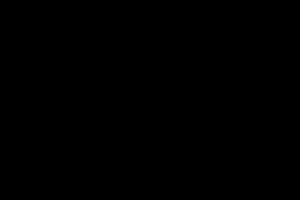

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([0. 0. 1. 0. 0. 0.], shape=(6,), dtype=float64)
[1.0012112  0.8406806  0.91945493]


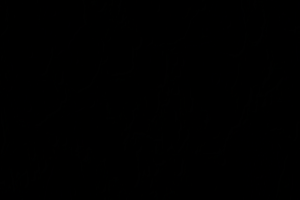

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float64)
[0.9700097 0.9778347 0.9386251]


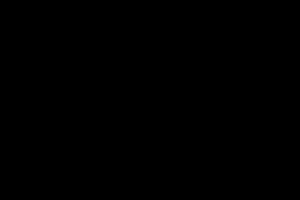

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float64)
[0.3790058  0.55942667 0.66922355]


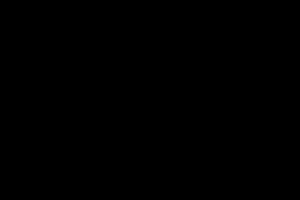

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float64)
[0.9323505 0.9738771 0.9262489]


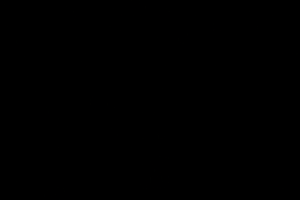

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float64)
[0.97257745 0.9686723  0.9370904 ]


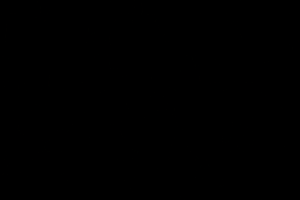

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float64)
[0.9451202  0.97019625 0.91207516]


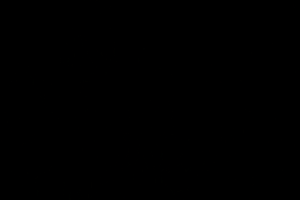

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float64)
[-0.3329919  -0.04256022  0.2413472 ]


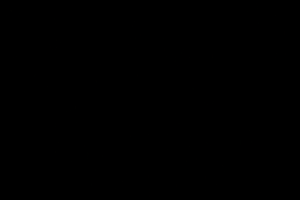

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float64)
[0.9782357 0.9782735 0.9624741]


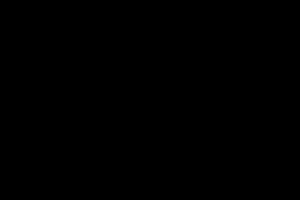

images shape  tf.Tensor([200 300   3], shape=(3,), dtype=int32)
label  tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float64)
[0.23956263 0.4758383  0.312338  ]


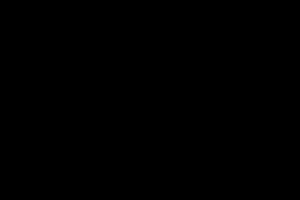

[200 300   3]


In [ ]:
#view some of the images from the training set to make sure they seem as expected

def view_train_images(train_ds):
  x=0
  for images,labels in train_ds.take(10):
    print('images shape ' ,tf.shape(images))
    print('label ',labels)
    image_out = images.numpy()
    print(image_out[0][0]) #show first pixel value across 3 channels
    cv2_imshow(image_out)
    x+=1
    if x > 9:
      image_shape = np.asarray(tf.shape(images))
      print(image_shape)
      return image_shape
    else:
      continue
    

image_shape = view_train_images(train_ds_mixed)

In [ ]:
#define model backbone

# backbone_mixed = xception.Xception(include_top=False,
#     weights='imagenet',
#     input_shape=(224,224,3))

backbone_mixed = inception(include_top=False,
    weights='imagenet', #was 'imagenet'
    input_shape=(TARGET_DIMS[0],TARGET_DIMS[1],3))

# backbone = efficientnet(include_top=False,
#     weights='imagenet',
#     input_shape=(image_shape[0],image_shape[1],image_shape[2]))

# backbone = rs50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(image_shape[0],image_shape[1],image_shape[2]))

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
backbone_mixed.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 149, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 149, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
#define and compile mixed
def define_compile_model_mixed(backbone):
  #choose pretrained model backbone to use , return compiled model 

  #reset backend so we don't have training data from previous experiments/runs
  tf.keras.backend.clear_session()
  
  # #define model architecture
  for layer in backbone.layers: #freeze all layers to take advantage of imagenet weights
    layer.trainable = False

  for layer in backbone.layers[-15:]: #unfreeze the last 15 layers so the model can learn features specific to our dataset
    layer.trainable = True

  #take the output layer from the backbone and flatten it
  f1 = Flatten()(backbone.output)
  #drop out some neurons so model does not rely too heavily on certain neurons to make predictions
  dr1 = Dropout(0.3)(f1) 
  #pass output through basic nn and reduce down into 6 neurons , each one matching a specific bethesda class
  d1 = Dense(400, activation='relu')(dr1)
  d2 = Dense(200, activation='relu')(d1)
  d3 = Dense(100, activation='relu')(d2)
  output = Dense(6, activation='softmax')(d3)

  #define the entire model
  model = Model(backbone.input, output)

  #compile model including metrics to log and optimiser to use
  metrics_list = [tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
                  tfa.metrics.F1Score(num_classes=6,threshold=None,average='macro',name = 'f1_score'),
                  tf.keras.metrics.Recall(name='sensitivity/recall'),
                  specificity,
                  tf.keras.metrics.AUC(curve='ROC',name='AUC',multi_label=True,num_labels=6)]


  model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics= metrics_list)
  
  return model

model_compiled_mixed = define_compile_model_mixed(backbone_mixed)

In [ ]:
#load entire model if needed to resume training

# metrics_list = [tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
#                   tfa.metrics.F1Score(num_classes=6,threshold=None,average='macro',name = 'f1_score'),
#                   tf.keras.metrics.Recall(name='sensitivity/recall'),
#                   specificity,
#                   tf.keras.metrics.AUC(curve='ROC',name='AUC',multi_label=True,num_labels=6)]

# model_compiled_mixed = tf.keras.models.load_model(mixed_models_best+'xception_minus15.h5',
#                                                   custom_objects={'specificity':specificity,
#                                                                'f1_score':tfa.metrics.F1Score(num_classes=6,threshold=None,average='macro',name = 'f1_score')})
                                               

In [ ]:
#load best weights from current run if needed to resume training
# model_compiled_mixed.load_weights(mixed_models_current+'current_run')

In [ ]:
#train mixed model

#define callbacks 

#early stopping to prevent over training
callback_early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=3, verbose=0, mode='auto',
      baseline=None, restore_best_weights=False) 

#save best weights each epoch
saving_callback_mixed = tf.keras.callbacks.ModelCheckpoint(
    filepath=mixed_models_current+'current_run',
    monitor='val_cat_accuracy',
    verbose=0,
    save_best_only = True,
    save_weights_only  = True)

#train the model, return trained model object and training history
def train_model_mi(compiled_model,train_ds_opt, valid_ds_opt, EPOCHS):
  
  trained_model = compiled_model
  history = trained_model.fit(
    train_ds_opt,
    validation_data=valid_ds_opt,
    epochs=EPOCHS,
    steps_per_epoch=int(len(x_train_mi)/64),
    validation_steps=5,
    verbose=1,
    callbacks=[callback_early_stopping,saving_callback_mixed])
  return trained_model, history

model_trained_mi, history_mi = train_model_mi(model_compiled_mixed, train_ds_mixed_opt, val_ds_mixed_opt, 20)

Epoch 1/20
101/101 [==============================] - 52s 485ms/step - loss: 0.3937 - cat_accuracy: 0.8518 - f1_score: 0.8515 - sensitivity/recall: 0.8303 - specificity: 0.9756 - AUC: 0.9805 - val_loss: 0.6995 - val_cat_accuracy: 0.7406 - val_f1_score: 0.7428 - val_sensitivity/recall: 0.7188 - val_specificity: 0.9563 - val_AUC: 0.9539
Epoch 2/20
101/101 [==============================] - 52s 514ms/step - loss: 0.3590 - cat_accuracy: 0.8727 - f1_score: 0.8726 - sensitivity/recall: 0.8574 - specificity: 0.9787 - AUC: 0.9831 - val_loss: 0.6847 - val_cat_accuracy: 0.7969 - val_f1_score: 0.7834 - val_sensitivity/recall: 0.7875 - val_specificity: 0.9650 - val_AUC: 0.9627
Epoch 3/20
101/101 [==============================] - 51s 506ms/step - loss: 0.3407 - cat_accuracy: 0.8776 - f1_score: 0.8775 - sensitivity/recall: 0.8646 - specificity: 0.9797 - AUC: 0.9852 - val_loss: 0.6835 - val_cat_accuracy: 0.8156 - val_f1_score: 0.8127 - val_sensitivity/recall: 0.8000 - val_specificity: 0.9663 - val_A

### Show model training metrics

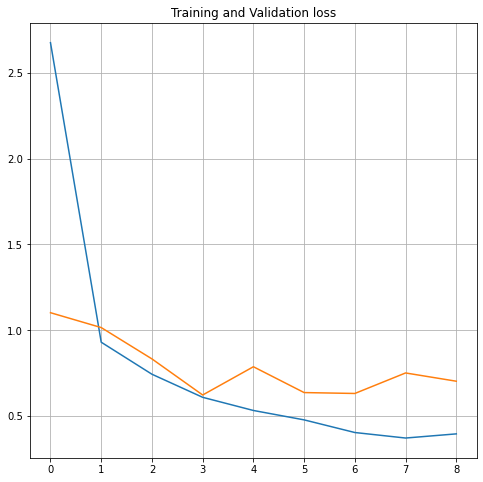

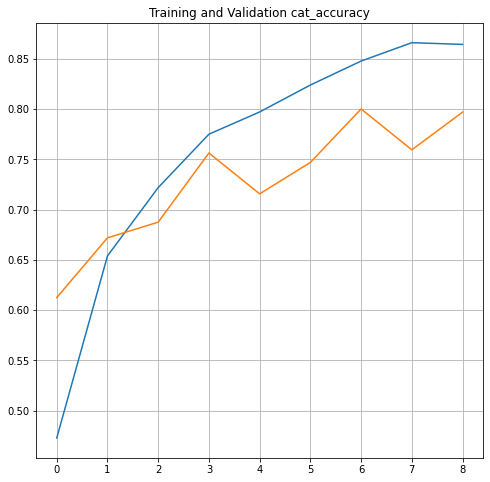

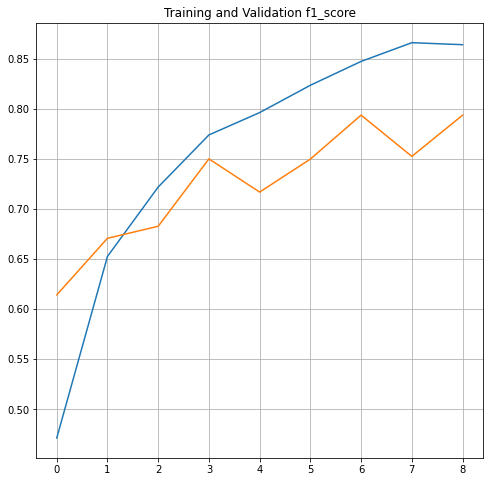

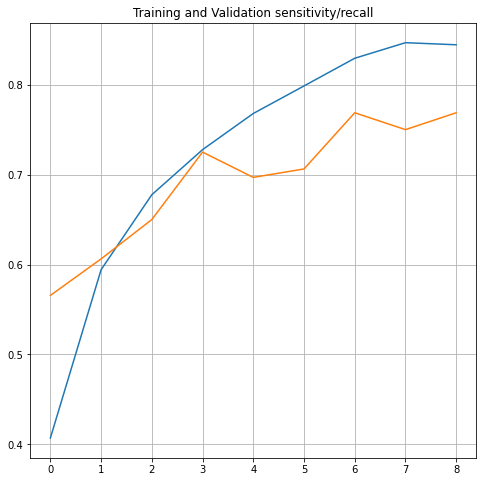

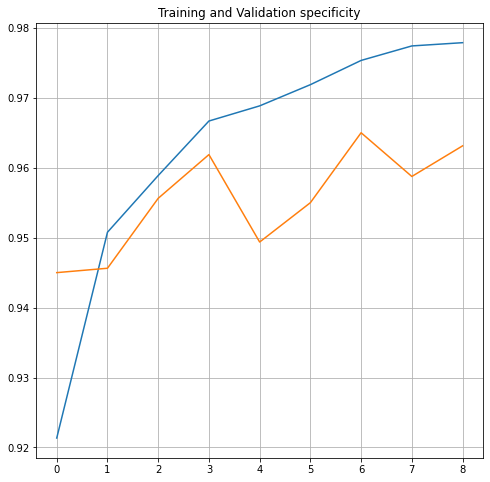

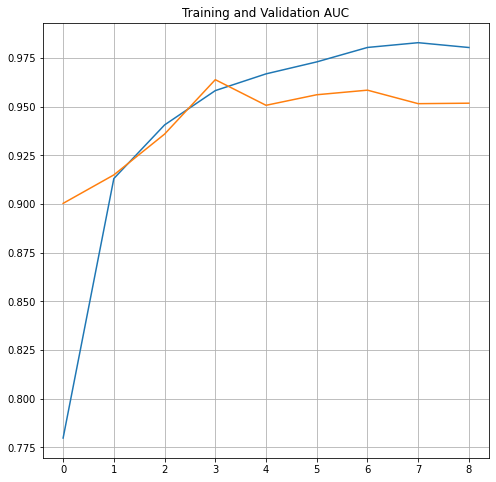

{'val_loss': 0.632, 'val_cat_accuracy': 0.8, 'val_f1_score': 0.794, 'val_sensitivity/recall': 0.769, 'val_specificity': 0.965, 'val_AUC': 0.958}


In [ ]:
best_metrics_dict_mi_current_run = show_training_metrics(model_trained_mi, history_mi)

In [ ]:
#if model has better metrics than current best performing model, we save as a .h5 file
# model_compiled_mixed.save(mixed_models_best+'xception_minus15.h5')

### Make predictions against validation set

In [ ]:
#load best weights from current run if needed
model_trained_mi.load_weights(mixed_models_current+'current_run')

In [ ]:
#load entire model if needed
# model_trained_mi = tf.keras.models.load_model(mixed_models_best+'xception_minus15.h5',
#                                                custom_objects={'specificity':specificity,
#                                                                'f1_score':tfa.metrics.F1Score(num_classes=6,threshold=None,average='macro',name = 'f1_score')})

In [ ]:
#make predictions on validation set
y_trues_oh_mi_val1 ,y_preds_oh_mi_val1 = get_oh_preds_class_label(val_ds_1_mixed, model_trained_mi)

#convert back to integer class label encodings
y_trues_cl_mi_val1 = enc.inverse_transform(y_trues_oh_mi_val1)
y_preds_cl_mi_val1 = enc.inverse_transform(y_preds_oh_mi_val1)

[[114   1  10   2   2   1]
 [  5  97   4  15   2   0]
 [  1   5 103   3  11   0]
 [  3  10   2  96   3   0]
 [  4   2  17   2  78  14]
 [  1   0   0   0   4 108]]


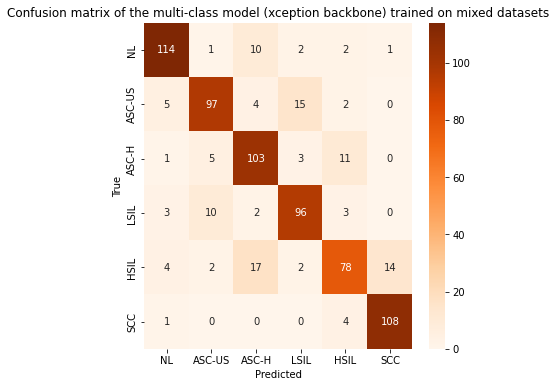

val cat accuracy: 0.828
val f1 macro: 0.826
val sensitivity/recall: 0.827
              precision    recall  f1-score   support

          NL      0.891     0.877     0.884       130
      ASC-US      0.843     0.789     0.815       123
       ASC-H      0.757     0.837     0.795       123
        LSIL      0.814     0.842     0.828       114
        HSIL      0.780     0.667     0.719       117
         SCC      0.878     0.956     0.915       113

    accuracy                          0.828       720
   macro avg      0.827     0.828     0.826       720
weighted avg      0.828     0.828     0.826       720



In [ ]:
#evaluate predictions
eval_predictions(y_trues_cl_mi_val1,y_preds_cl_mi_val1,'multi-class model (xception backbone) trained on mixed datasets') 

### Testing specific images:

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/ASC-H_121.jpg')

In [ ]:
resized_test_image = resize_tr(image=test_img)['image']

In [ ]:
ready_test_image = tf.keras.applications.xception.preprocess_input(resized_test_image)

In [ ]:
test_pred = model_trained_mi.predict(np.expand_dims(ready_test_image,axis=0))

In [ ]:
test_pred